# Introduction
Thanks for taking a look at this notebook!   
This notebook introduces the beginning machine learning student to how to create a **Neural Network** using **PyTorch** and other commonly used methods in machine learning.  
  
In this notebook, I will address as follows: 
*  How to build a Neural Network by using **PyTorch**
*  How to use Pytorch and GPU for efficient learning
*  Hyperparameter tuning using by **optuna**
*  Improve generalization performance by **k-fold cross-validation**  

## General flow of Pytorch
The flow of Neural Network learning with Pytorch is shown in the figure below.  
Basically the same as other machine learning flows, but the orange areas are specific to PyTorch.  
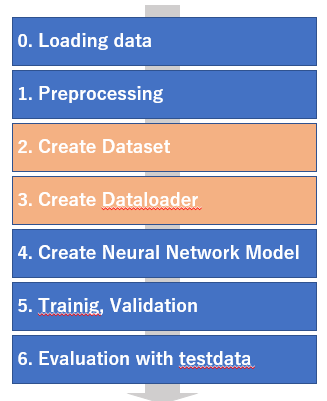  
In the following, I will implement the code according to this flow

# Module Load
Import the module to be used this notebook.  
Also, check to see if the GPU is ready for use.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Active device：', device)

# Loading Data
First, download the data using `pandas` and check the contents

In [ ]:
train_df = pd.read_csv('../input/tabular-playground-series-may-2022/train.csv')
test_df = pd.read_csv('../input/tabular-playground-series-may-2022/test.csv')

In [ ]:
print(train_df.shape)  # check the shape
train_df.head(10)

In [ ]:
print(test_df.shape)
test_df.head(10)

# Preprocessing
Perform preprocessing to make it into a form that can be handled by the neural network.  
First, specify `id` as the index name to make it easier to handle data in the future.

In [ ]:
train_df.set_index(keys='id', inplace=True)
test_df.set_index(keys='id', inplace=True)
train_df.head()

Separate objective and explanatory variables in `train_df`

In [ ]:
train_df_y = train_df['target']
train_df.drop(['target'], axis=1, inplace=True)
train_df_y.head()

Combine the test and training data for processing.

In [ ]:
ntrain = train_df.shape[0]
all_data = pd.concat((train_df, test_df))
print(all_data.shape)
all_data.head()

Check data type and missing information

In [ ]:
all_data.info()

Perform feature engineering with reference to the written Discussion.  
>**Referance**  
https://www.kaggle.com/code/ambrosm/tpsmay22-advanced-keras  
https://www.kaggle.com/competitions/tabular-playground-series-may-2022/discussion/323892

In [ ]:
def feature_engineering(df):
    for i in range(10):
        df[f'ch{i}'] = df.f_27.str.get(i).apply(ord) - ord('A')
    df["unique_characters"] = df.f_27.apply(lambda s: len(set(s)))
    df['i_02_21'] = (df.f_21 + df.f_02 > 5.2).astype(int) - (df.f_21 + df.f_02 < -5.3).astype(int)
    df['i_05_22'] = (df.f_22 + df.f_05 > 5.1).astype(int) - (df.f_22 + df.f_05 < -5.4).astype(int)
    i_00_01_26 = df.f_00 + df.f_01 + df.f_26
    df['i_00_01_26'] = (i_00_01_26 > 5.0).astype(int) - (i_00_01_26 < -5.0).astype(int)
    return df
all_data = feature_engineering(all_data)
all_data.head()

Delete `f_27`.

In [ ]:
all_data = all_data.drop('f_27', axis=1)
all_data.head()

Return to train_df and test_df

In [ ]:
train_df = all_data[:ntrain]
test_df = all_data[ntrain:]
print(train_df.shape, test_df.shape)
train_df.head()

**Split the data**  
Split train_df into training and test data for model training and generalization performance validation.

In [ ]:
# pandas -> numpy
X = train_df.values
y = train_df_y.values
print(X.shape, y.shape)
# Split training and test data(30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1, stratify=y)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

**Standerd Scaler**  
Standardize data using sklearn `StanderdScaler`

In [ ]:
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.fit_transform(X_test)

# Create Dataset
How to create Dataset using torch `TensorDataset`  
```Python
train_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_train_std), torch.tensor(y_train))
test_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_test_std))
```

# Create Dataloader
How to create Dataset using torch `Dataloader`  
```Python
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)
```

# Create Neural Network Model
Use PyTorch to create Neural Network.  
Here, a simple Affine network is created. The number of hidden layers and the number of nodes can be parameter-tuned.

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size, num_layer, num_nodes, dropout_rate, activation_name):
        super(Net, self).__init__()
        self.activation = get_activation(activation_name)
        # First layer
        self.linears = nn.ModuleList([nn.Linear(input_size, num_nodes[0])])
        self.batchnorms = nn.ModuleList([nn.BatchNorm1d(num_nodes[0])])
        # After the second layer
        for i in range(1, num_layer):
            self.linears.append(nn.Linear(num_nodes[i-1], num_nodes[i]))
            self.batchnorms.append(nn.BatchNorm1d(num_nodes[i]))
        # final layer
        self.fcl = nn.Linear(num_nodes[-1], 1)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        for i, d in enumerate(zip(self.linears, self.batchnorms)):
            l, b = d[0], d[1]
            x = b(self.activation(l(x)))
            x = self.dropout(x)
        x = torch.sigmoid(self.fcl(x))
        return x

In the following, we have defined each of the functions needed to train a neural network.

In [ ]:
# Function to obtain the activation function
def get_activation(activation_name):
    if activation_name == 'Relu':
        activation = F.relu
    elif activation_name == 'ELU':
        activation = F.elu
    else:
        activation = F.leaky_relu
    return activation

# Function to get optimize method
def get_optimizer(model, optimizer_name, lr, weight_decay):
    if optimizer_name == 'MomentumSGD': 
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    elif optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'Adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=lr, weight_decay=weight_decay)      
    else:
        optimizer = torch.optim.RMSprop(model.parameters())
    return optimizer

# Function to train Neural Network
def train(model, train_dataloader, optimizer):
    # check whether GPU is available
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    # Define the error function
    criterion = nn.MSELoss()
    #　Model in learning mode
    model.train()
    #　If the network is somewhat fixed, make it faster
    torch.backends.cudnn.benchark = True
    # epoch loss
    epoch_loss = 0
    iteration = 0
    for batch, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        output = output.view(1, -1)[0]
        # print(output.shape, target.shape)
        target = target.to(torch.float32)
        loss = criterion(output, target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        iteration += 1
    epoch_loss /= iteration
    return epoch_loss

# Function for prediction
def predict(model, dataloader):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.eval()
    model.to('cpu')
    y_pred = np.array([])
    with torch.no_grad():
        for data in dataloader:
            data = data[0]
            output = model(data)
            output = output.view(1, -1)
            output = output.to('cpu').detach().numpy().copy()
            y_pred = np.append(y_pred, output[0])
        y_pred = np.array(y_pred)
    return y_pred

# Function for plot loss function of each epoch
def loss_plot(logs_train, logs_valid):
    plt.plot(logs_train[0][1:], logs_train[1][1:], '-b', label='train')
    plt.plot(logs_valid[0][1:], logs_valid[1][1:], '-r', label='test')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

In [ ]:
params = {'num_layer': 2, 
          'num_nodes_0': 24, 
          'num_nodes_1': 12, 
          'dropout_rate': 0.5, 
          'activation': 'leaky_relu', 
          'optimizer': 'Adam', 
          'weight_decay': 1e-10, 
          'Adam_lr': 0.01}

# Training, Validation
Ready for training, perform k-fold cross-validation and train the model.  
The flow of k-fold cross-validation (for k=5) is shown below  

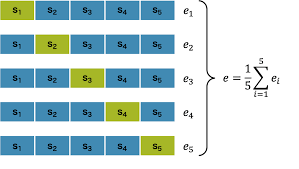

In [ ]:
# from tqdm import tqdm
### prameter
k_split = 10
num_epochs = 50
batch_size = 1024
###

# k-fold cross-validation
kfold = StratifiedKFold(n_splits=k_split,
                        random_state=1, shuffle=True).split(X_train_std, y_train)
#### get parameter
num_layer = params['num_layer']
num_nodes = [int(params[s]) for s in params.keys() if 'num_nodes' in s]
dropout_rate = params['dropout_rate']
activation_name = params['activation']
optimizer_name = params['optimizer']
lr = params[optimizer_name+'_lr']
weight_decay = params['weight_decay']
######

scores = []   # list to save score 
models = []   # list to save model
for k, (train_id, test_id) in enumerate(kfold):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    # Instantiate Model
    model = Net(input_size=X_train_std.shape[1],
                num_layer=num_layer, 
                num_nodes=num_nodes, 
                dropout_rate=dropout_rate, 
                activation_name=activation_name)
    # model to GPU
    model.to(device)
    optimizer = get_optimizer(model, optimizer_name, lr, weight_decay)
    # data to dataloader
    dataset = torch.utils.data.TensorDataset(torch.Tensor(X_train_std[train_id]), torch.tensor(y_train[train_id]))
    train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    valid_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_train_std[test_id]))
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)
    # training each epoch
    logs_train = [[0], [np.inf]]
    logs_valid = [[0], [np.inf]]
    for epoch in tqdm(range(num_epochs)):
        epoch_loss = train(model, train_dataloader, optimizer)
        valid_pred = predict(model, valid_dataloader)
        valid_loss = mean_squared_error(y_train[test_id], valid_pred)
        if epoch_loss < min(logs_valid[1]):
            torch.save(model.state_dict(), './models'+str(k))
        logs_train[0].append(epoch+1)
        logs_train[1].append(epoch_loss)
        logs_valid[0].append(epoch+1)
        logs_valid[1].append(valid_loss)   
    # valid
    model.load_state_dict(torch.load('./models'+str(k)))
    pred_y_k = predict(model, valid_dataloader)
    # score
    score = roc_auc_score(y_train[test_id], pred_y_k)
    print('Fold: %2d, AUC: %.3f' % (k+1, score))
    scores.append(score)
    models.append(model)
    loss_plot(logs_train, logs_valid)
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

# Evaluation with testdata
Define a function to predict and summarize the results in each of the models created by the k-fold cross-validation.

In [ ]:
def predict_kfold(models, X_test):
    # Create array for storing test data
    y_pred = np.zeros((len(X_test), len(models)))
    # Crate dataloader
    test_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_test))
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=512)
    for fold_, model_ in enumerate(models):
        model_.load_state_dict(torch.load('./models'+str(fold_)))
        # predict
        pred_ = predict(model_, test_dataloader)
        # store
        y_pred[:, fold_] = pred_ 
    y_pred = y_pred.mean(axis=1)
    return y_pred
y_pred = predict_kfold(models, X_test_std)

calclate `auc` and `roc curves` and evaluate performance on test data

In [ ]:
roc = roc_curve(y_test, y_pred)
print("roc", roc_auc_score(y_test, y_pred))
fpr, tpr, thresholds = roc
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

Try the same calculations on training data.

In [ ]:
y_pred_train = predict_kfold(models, X_train_std)
roc = roc_curve(y_train, y_pred_train)
print("roc", roc_auc_score(y_train, y_pred_train))
fpr, tpr, thresholds = roc
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

# Submit data
Apply model to test_df and create submit data

In [ ]:
X_submit = test_df.values
X_submit_std = stdsc.transform(X_submit)
y_submit = predict_kfold(models, X_submit_std)
print(y_submit)
print(y_submit.shape)
plt.hist(y_submit, bins=30, density=True)
plt.show()

In [ ]:
submission_df = pd.read_csv('../input/tabular-playground-series-may-2022/sample_submission.csv')
print(submission_df.shape)
submission_df.head()

In [ ]:
submission_df['target'] = pd.DataFrame(y_submit)
submission_df.head()

In [ ]:
submission_df.to_csv("submission.csv", index=False, header=True)

# Hyperparameter Tuning
In the following, I present a method of hyperparameter tuning using a technique called optuna.

First, split the training data into data used for training and data used for tuning.  
And then standardize.

In [ ]:
valid_size = 0.1
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=valid_size, stratify=y_train)
print(X_train.shape, X_valid.shape)
print(y_train.shape, y_valid.shape)
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_valid_std = stdsc.transform(X_valid)
train_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_train_std), torch.tensor(y_train))
valid_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_valid_std), torch.tensor(y_valid))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=512)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=512)

Tuning is performed below using optuna.  
Here, we define `trial` and explore each parameter

In [ ]:
# define the class
class Net(nn.Module):
    def __init__(self, trial, input_size, num_layer, num_nodes, dropout_rate):
        super(Net, self).__init__()
        self.activation = get_activation(trial)
        self.linears = nn.ModuleList([nn.Linear(input_size, num_nodes[0])])
        self.batchnorms = nn.ModuleList([nn.BatchNorm1d(num_nodes[0])])
        for i in range(1, num_layer):
            self.linears.append(nn.Linear(num_nodes[i-1], num_nodes[i]))
            self.batchnorms.append(nn.BatchNorm1d(num_nodes[i]))
        self.fcl = nn.Linear(num_nodes[-1], 1)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        for i, d in enumerate(zip(self.linears, self.batchnorms)):
            l, b = d[0], d[1]
            x = b(self.activation(l(x)))
            x = self.dropout(x)
        x = torch.sigmoid(self.fcl(x))
        return x

In [ ]:
def train(model, device, train_dataloader, optimizer):
    model.train()
    criterion = nn.MSELoss()
    for batch, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        output = output.view(1, -1)[0]
        # print(output.shape, target.shape)
        target = target.to(torch.float32)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
def test(model, device, valid_dataloader):
    model.eval()
    criterion = nn.MSELoss()
    loss = 0
    iteration = 0
    with torch.no_grad():
        for data, target in valid_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            output = output.view(1, -1)[0]
            loss += criterion(output, target)
            iteration += 1
    loss /= iteration
    return loss

In [ ]:
def get_optimizer(trial, model):
    optimizer_names = ['MomentumSGD', 'Adam', 'Adagrad']
    optimizer_name = trial.suggest_categorical('optimizer', optimizer_names)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
    if optimizer_name == optimizer_names[0]: 
        momentum_sgd_lr = trial.suggest_loguniform('Momentum_SGD_lr', 1e-5, 1e-1)
        optimizer = torch.optim.SGD(model.parameters(), lr=momentum_sgd_lr, momentum=0.9, weight_decay=weight_decay)
    elif optimizer_name == optimizer_names[1]:
        adam_lr = trial.suggest_loguniform('Adam_lr', 1e-5, 1e-1)
        optimizer = torch.optim.Adam(model.parameters(), lr=adam_lr, weight_decay=weight_decay)
    elif optimizer_name == optimizer_names[2]:
        adagrad_lr = trial.suggest_loguniform('Adagrad_lr', 1e-5, 1e-1)
        optimizer = torch.optim.Adagrad(model.parameters(), lr=adagrad_lr, weight_decay=weight_decay)      
    return optimizer

In [ ]:
def get_activation(trial):
    activation_names = ['ReLU', 'ELU', 'leaky_relu']
    activation_name = trial.suggest_categorical('activation', activation_names)
    if activation_name == activation_names[0]:
        activation = F.relu
    elif activation_name == activation_names[1]:
        activation = F.elu
    else:
        activation = F.leaky_relu
    return activation

In [ ]:
epochs = 30
def objective(trial):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    # hidden layer
    num_layer = trial.suggest_int('num_layer', 2, 7)
    # the number of nodes
    num_nodes = [int(trial.suggest_discrete_uniform('num_nodes_'+str(i), 16, 128, 16)) for i in range(num_layer)]
    # dropout ratio
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 1.0)

    model = Net(trial, X_train.shape[1],num_layer, num_nodes, dropout_rate).to(device)
    optimizer = get_optimizer(trial, model)
    error_rate = 0
    for epoch in range(epochs):
        train(model, device, train_dataloader, optimizer)
    error_rate = test(model, device, valid_dataloader)
    return error_rate

In [ ]:
# import optuna
# TRIAL_SIZE = 100
# study = optuna.create_study()
# study.optimize(objective, n_trials=TRIAL_SIZE)
# best_params = study.best_params
# print(best_params)

In [ ]:
# params = best_params
params = {'num_layer': 4, 'num_nodes_0': 128.0, 'num_nodes_1': 112.0, 'num_nodes_2': 96.0, 'num_nodes_3': 96.0, 'dropout_rate': 0.08387843261849516, 'activation': 'ReLU', 'optimizer': 'Adam', 'weight_decay': 2.227219890291524e-09, 'Adam_lr': 0.0019802197708342255}

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size, num_layer, num_nodes, dropout_rate, activation_name):
        super(Net, self).__init__()
        self.activation = get_activation(activation_name)
        # first layer
        self.linears = nn.ModuleList([nn.Linear(input_size, num_nodes[0])])
        self.batchnorms = nn.ModuleList([nn.BatchNorm1d(num_nodes[0])])
        # after second layer
        for i in range(1, num_layer):
            self.linears.append(nn.Linear(num_nodes[i-1], num_nodes[i]))
            self.batchnorms.append(nn.BatchNorm1d(num_nodes[i]))
        # last layer
        self.fcl = nn.Linear(num_nodes[-1], 1)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        for i, d in enumerate(zip(self.linears, self.batchnorms)):
            l, b = d[0], d[1]
            x = b(self.activation(l(x)))
            x = self.dropout(x)
        x = torch.sigmoid(self.fcl(x))
        return x

def get_activation(activation_name):
    if activation_name == 'Relu':
        activation = F.relu
    elif activation_name == 'ELU':
        activation = F.elu
    else:
        activation = F.leaky_relu
    return activation

In [ ]:
def train(model, train_dataloader, optimizer):
    # check whether GPU is available
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    # Define the error function
    criterion = nn.MSELoss()
    #　Model in learning mode
    model.train()
    #　If the network is somewhat fixed, make it faster
    torch.backends.cudnn.benchark = True
    # epoch loss
    epoch_loss = 0
    iteration = 0
    for batch, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        output = output.view(1, -1)[0]
        # print(output.shape, target.shape)
        target = target.to(torch.float32)
        loss = criterion(output, target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        iteration += 1
    epoch_loss /= iteration
    return epoch_loss
def predict(model, dataloader):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.eval()
    model.to('cpu')
    y_pred = np.array([])
    with torch.no_grad():
        for data in dataloader:
            data = data[0]
            output = model(data)
            output = output.view(1, -1)
            output = output.to('cpu').detach().numpy().copy()
            y_pred = np.append(y_pred, output[0])
        y_pred = np.array(y_pred)
    return y_pred
def get_optimizer(model, optimizer_name, lr, weight_decay):
    if optimizer_name == 'MomentumSGD': 
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    elif optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'Adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=lr, weight_decay=weight_decay)      
    else:
        optimizer = torch.optim.RMSprop(model.parameters())
    return optimizer
def loss_plot(logs_train, logs_valid):
    plt.plot(logs_train[0][1:], logs_train[1][1:], '-b', label='train')
    plt.plot(logs_valid[0][1:], logs_valid[1][1:], '-r', label='test')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

In [ ]:
from tqdm import tqdm
### prameter
k_split = 10
num_epochs = 50
batch_size = 1024

# k-fold cross-validation
kfold = StratifiedKFold(n_splits=k_split,
                        random_state=1, shuffle=True).split(X_train_std, y_train)
# get parameter
num_layer = params['num_layer']
num_nodes = [int(params[s]) for s in params.keys() if 'num_nodes' in s]
dropout_rate = params['dropout_rate']
activation_name = params['activation']
optimizer_name = params['optimizer']
lr = params[optimizer_name+'_lr']
weight_decay = params['weight_decay']

scores = []   # list to save score 
models = []   # list to save model
for k, (train_id, test_id) in enumerate(kfold):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    # Instantiate Model
    model = Net(input_size=X_train_std.shape[1],
                num_layer=num_layer, 
                num_nodes=num_nodes, 
                dropout_rate=dropout_rate, 
                activation_name=activation_name)
    # model to GPU
    model.to(device)
    optimizer = get_optimizer(model, optimizer_name, lr, weight_decay)
    # data to dataloader
    dataset = torch.utils.data.TensorDataset(torch.Tensor(X_train_std[train_id]), torch.tensor(y_train[train_id]))
    train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    valid_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_train_std[test_id]))
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)
    # training each epoch
    logs_train = [[0], [np.inf]]
    logs_valid = [[0], [np.inf]]
    for epoch in tqdm(range(num_epochs)):
        epoch_loss = train(model, train_dataloader, optimizer)
        valid_pred = predict(model, valid_dataloader)
        valid_loss = mean_squared_error(y_train[test_id], valid_pred)
        if epoch_loss < min(logs_valid[1]):
            torch.save(model.state_dict(), './models'+str(k))
        logs_train[0].append(epoch+1)
        logs_train[1].append(epoch_loss)
        logs_valid[0].append(epoch+1)
        logs_valid[1].append(valid_loss)   
    # valid
    model.load_state_dict(torch.load('./models'+str(k)))
    pred_y_k = predict(model, valid_dataloader)
    # score
    score = roc_auc_score(y_train[test_id], pred_y_k)
    print('Fold: %2d, AUC: %.3f' % (k+1, score))
    scores.append(score)
    models.append(model)
    loss_plot(logs_train, logs_valid)
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

In [ ]:
X_test_std = stdsc.transform(X_test)
y_pred = predict_kfold(models, X_test_std)
print(y_pred)
print(y_test)

In [ ]:
roc = roc_curve(y_test, y_pred)
print("roc", roc_auc_score(y_test, y_pred))
fpr, tpr, thresholds = roc
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

In [ ]:
y_pred_train = predict_kfold(models, X_train_std)
roc = roc_curve(y_train, y_pred_train)
print("roc", roc_auc_score(y_train, y_pred_train))
fpr, tpr, thresholds = roc
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

In [ ]:
X_submit = test_df.values
X_submit_std = stdsc.transform(X_submit)
y_submit = predict_kfold(models, X_submit_std)
print(y_submit)
print(y_submit.shape)
plt.hist(y_submit, bins=30, density=True)
plt.show()

In [ ]:
submission_df = pd.read_csv('../input/tabular-playground-series-may-2022/sample_submission.csv')
print(submission_df.shape)
submission_df.head()

In [ ]:
submission_df['target'] = pd.DataFrame(y_submit)
submission_df.head()

In [ ]:
submission_df.to_csv("submission.csv", index=False, header=True)